In [17]:
#loading train and test datasets
train = pd.read_csv("/Users/arg000m/Downloads/travel_time/train.csv")
test = pd.read_csv("/Users/arg000m/Downloads/travel_time/test.csv")

In [18]:
# loading libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics
import xgboost as xgb
from haversine import haversine
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [19]:
train.head()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
0,0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112
1,1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159
2,2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281
3,3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636
4,4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705


In [20]:
# basic data summary
train.describe()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
count,12905715.000000,12905715.000000,12905715.000000,12905715.000000,12905715.000000,1.290572e+07,12905715.000000
mean,6452857.000000,-73.973822,40.750647,-73.973579,40.751406,1.435380e+09,842.141953
std,3725559.159012,0.038003,0.027897,0.035899,0.031921,9.079600e+06,712.748918
min,0.000000,-74.514618,40.368916,-74.517853,40.368874,1.420099e+09,1.000000
25%,3226428.500000,-73.992058,40.736973,-73.991425,40.735523,1.427509e+09,400.000000
50%,6452857.000000,-73.981956,40.753590,-73.980087,40.754078,1.434868e+09,665.000000
75%,9679285.500000,-73.967735,40.767925,-73.963509,40.769054,1.443342e+09,1076.000000
max,12905714.000000,-73.414452,41.031418,-73.414352,41.031509,1.451635e+09,43178.000000


In [21]:
# checking for null values 
train.isnull().sum(), test.isnull().sum()

(row_id             0
 start_lng          0
 start_lat          0
 end_lng            0
 end_lat            0
 start_timestamp    0
 duration           0
 dtype: int64, row_id             0
 start_lng          0
 start_lat          0
 end_lng            0
 end_lat            0
 start_timestamp    0
 dtype: int64)

In [22]:
# train, test, #train_col, # test_col
train.shape[0], test.shape[0], train.shape[1], test.shape[1]


(12905715, 1434344, 7, 6)

In [23]:
#checking for unique ID column
train.row_id.nunique() == train.shape[0]


True

In [24]:
# Getting the common Id's. From the intersection value we can conclude that the testing id's are a subset of training 
# ID's
import numpy as np
len(np.intersect1d(train.row_id.values, test.row_id.values))

1434344

In [25]:
# checking for missing values 
train.count().min() == train.shape[0] and test.count().min() == test.shape[0]

True

In [26]:
# converting unix time to standard time
import datetime

train['start_times'] = pd.to_datetime(train['start_timestamp'],unit='s')

test['start_times'] = pd.to_datetime(test['start_timestamp'],unit='s')

In [27]:
train.head()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,start_times
0,0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112,2015-01-11 04:33:39
1,1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159,2015-01-11 04:33:39
2,2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281,2015-01-16 03:05:41
3,3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636,2015-01-16 03:05:42
4,4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705,2015-01-25 08:13:06


In [28]:
 test.head()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,start_times
0,0,-73.993111,40.724289,-74.000977,40.735222,1422173589,2015-01-25 08:13:09
1,1,-73.971924,40.762749,-73.965698,40.771427,1420567340,2015-01-06 18:02:20
2,2,-73.953247,40.765816,-73.952843,40.772453,1420567343,2015-01-06 18:02:23
3,3,-73.986618,40.739353,-73.949158,40.805161,1420103336,2015-01-01 09:08:56
4,4,-73.968864,40.757317,-73.982521,40.771305,1420690180,2015-01-08 04:09:40


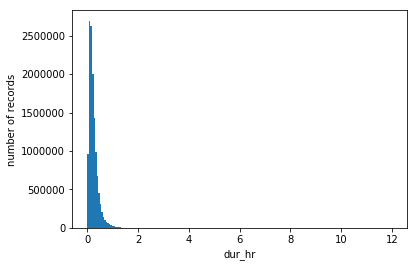

In [29]:
#checking distribution of the dependent variable
import matplotlib.pyplot as plt
train['dur_hr']=train['duration']/3600

train['dur_hr'] = train['dur_hr'].values
plt.hist(train['dur_hr'].values, bins=200)
plt.xlabel('dur_hr')
plt.ylabel('number of records')
plt.show()

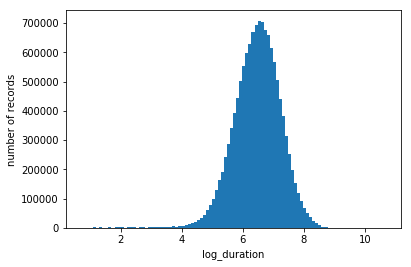

In [30]:
#checking distribution of the dependent variable
import matplotlib.pyplot as plt
train['log_duration'] = np.log1p(train['duration'].values)
plt.hist(train['log_duration'].values, bins=100)
plt.xlabel('log_duration')
plt.ylabel('number of records')
plt.show()

### log transformation is applied to reduce the skeweness.

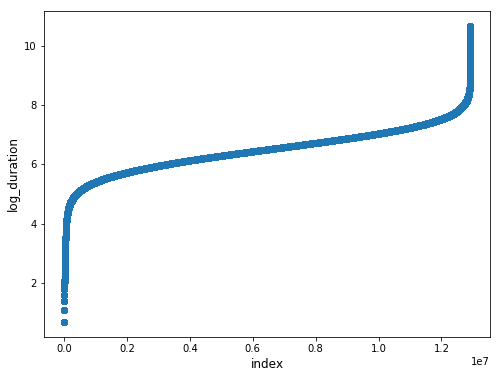

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.log_duration.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('log_duration', fontsize=12)
plt.show()

In [49]:
len(train[train['log_duration'] < 1.5])

4922

In [50]:
train = train[train['log_duration'] > 1.5]

#### Since dates are given as part of the dataset, it is essential to check whether the train and test datasets are from the same time period or different time period.
#### Validation as to do K-fold cross validation or doing K-fold cross validation with respect to time
#### in this case we find that the train and test dataset are for the same time period. Hence, we can do K-fold cross validaton

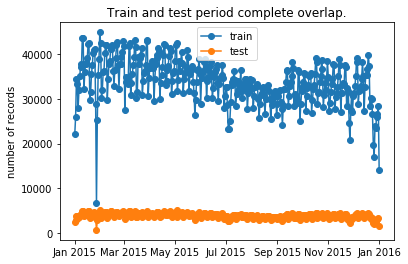

In [298]:
train.loc[:, 'start_date'] = train['start_times'].dt.date
test.loc[:, 'start_date'] = test['start_times'].dt.date

plt.plot(train.groupby('start_date').count()[['row_id']], 'o-', label='train')
plt.plot(test.groupby('start_date').count()[['row_id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

### feature engineering

In [51]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [ ]:
train.loc[:, 'distance_haversine'] = haversine_array(train['start_lat'].values, train['start_lng'].values, train['end_lat'].values, train['end_lng'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['start_lat'].values, test['start_lng'].values, test['end_lat'].values, train['end_lng'].values)

In [54]:
#Feature extraction from Datetime


train['hour_pick']=train.start_times.dt.hour
train['day_of_week']=train.start_times.dt.dayofweek
train['day_of_month']=train.start_times.dt.days_in_month
train['month']=train.start_times.dt.month
train['is_night_time']=[1 if (i==0 or i>=19)  else 0 for i in train['start_times'].dt.hour]
train['late_night_time']=[1 if (i<5 or i>0)  else 0 for i in train['start_times'].dt.hour]
train['week']=train['start_times'].dt.week
train['min_of_pick']=train['start_times'].dt.minute
train['weather']=[1 if (i in [1,2,3]) else(2 if (i in [4,11,12]) else 3) for i in train['month']]
train['quarter']=train.start_times.dt.quarter
train['center_lat']=(train['end_lat']-train['start_lat'])/2
train['center_long']=(train['end_lng']-train['start_lng'])/2
train['pickup_hour_weekofyear'] = train['start_times'].dt.weekofyear
train['pickup_week_hour'] = train['day_of_week'] * 24 + train['hour_pick']

test['hour_pick']=test.start_times.dt.hour
test['day_of_week']=test.start_times.dt.dayofweek
test['day_of_month']=test.start_times.dt.days_in_month
test['month']=test.start_times.dt.month
test['is_night_time']=[1 if (i==0 or i>=19)  else 0 for i in test['start_times'].dt.hour]
test['late_night_time']=[1 if (i<5 or i>0)  else 0 for i in test['start_times'].dt.hour]
test['week']=test['start_times'].dt.week
test['min_of_pick']=train['start_times'].dt.minute
test['weather']=[1 if (i in [1,2,3]) else(2 if (i in [4,11,12]) else 3) for i in test['month']]
test['quarter']=test.start_times.dt.quarter
test['center_lat']=(test['end_lat']-test['start_lat'])/2
test['center_long']=(test['end_lng']-test['start_lng'])/2
test['pickup_hour_weekofyear'] = test['start_times'].dt.weekofyear
test['pickup_week_hour'] = test['day_of_week'] * 24 + test['hour_pick']



# difference between pickup and dropoff latitudes #
train['lat_diff'] = train['start_lat'] - train['end_lat']
train['lon_diff'] = train['start_lng'] - train['end_lng']


# difference between pickup and dropoff longitudes #
test['lon_diff'] = test['start_lng'] - test['end_lng']
test['lat_diff'] = test['start_lat'] - test['end_lat']




In [55]:
from sklearn.cluster import MiniBatchKMeans
coords = np.vstack((train[['start_lat', 'start_lng']].values,
                    train[['end_lat', 'end_lng']].values))
sample_ind = np.random.permutation(len(coords))
kmeans = MiniBatchKMeans(n_clusters=90, batch_size=10000).fit(coords[sample_ind])

In [56]:
train.loc[:, 'start_cluster'] = kmeans.predict(train[['start_lat', 'start_lng']])
train.loc[:, 'end_cluster'] = kmeans.predict(train[['end_lat', 'end_lng']])


In [57]:
test.loc[:, 'start_cluster'] = kmeans.predict(test[['start_lat', 'start_lng']])
test.loc[:, 'end_cluster'] = kmeans.predict(test[['end_lat', 'end_lng']])

In [58]:
coords = np.vstack((train[['start_lat', 'start_lng']].values,
                    train[['end_lat', 'end_lng']].values,
                    test[['start_lat', 'start_lng']].values,
                    test[['end_lat', 'end_lng']].values))

from sklearn.decomposition import PCA
pca = PCA().fit(coords)
train['start_pca0'] = pca.transform(train[['start_lat', 'start_lng']])[:, 0]
train['start_pca1'] = pca.transform(train[['start_lat', 'start_lng']])[:, 1]
train['end_pca0'] = pca.transform(train[['end_lat', 'end_lng']])[:, 0]
train['end_pca1'] = pca.transform(train[['end_lat', 'end_lng']])[:, 1]
test['start_pca0'] = pca.transform(test[['start_lat', 'start_lng']])[:, 0]
test['start_pca1'] = pca.transform(test[['start_lat', 'start_lng']])[:, 1]
test['end_pca0'] = pca.transform(test[['end_lat', 'end_lng']])[:, 0]
test['end_pca1'] = pca.transform(test[['end_lat', 'end_lng']])[:, 1]



In [89]:
train.head()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,start_times,dur_hr,log_duration,distance_haversine,hour_pick,day_of_week,day_of_month,month,is_night_time,late_night_time,week,min_of_pick,weather,quarter,center_lat,center_long,pickup_hour_weekofyear,pickup_week_hour,lat_diff,lon_diff,start_cluster,end_cluster,start_pca0,start_pca1,end_pca0,end_pca1
0,0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112,2015-01-11 04:33:39,0.031111,4.727388,0.794604,4,6,31,1,0,1,2,33,1,1,0.003084,0.002380,2,148,-0.006168,-0.004761,3,67,-0.034492,0.038033,-0.029877,0.031756
1,1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159,2015-01-11 04:33:39,0.321944,7.056175,3.544615,4,6,31,1,0,1,2,33,1,1,-0.009887,-0.016503,2,148,0.019775,0.033005,62,31,0.002273,-0.011449,-0.030261,0.009091
2,2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281,2015-01-16 03:05:41,0.078056,5.641907,1.233276,3,4,31,1,0,1,3,5,1,1,-0.005214,-0.002491,3,99,0.010429,0.004982,76,6,-0.021096,0.006451,-0.025833,0.016993
3,3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636,2015-01-16 03:05:42,0.176667,6.456770,1.702320,3,4,31,1,0,1,3,5,1,1,-0.007595,0.001259,3,99,0.015190,-0.002518,18,29,-0.017384,0.001361,-0.014512,0.016489
4,4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705,2015-01-25 08:13:06,0.195833,6.559615,4.059491,8,6,31,1,0,1,4,13,1,1,-0.009009,-0.020961,4,152,0.018017,0.041923,79,87,0.027667,-0.023342,-0.013824,-0.004350


In [90]:
# drop off the variables which are not needed #
cols_to_drop = ['row_id', 'start_timestamp', 'start_times']
train_id = train['row_id'].values
test_id = test['row_id'].values

train_y = train.log_duration.values
train_X = train.drop(cols_to_drop + ['duration', 'log_duration','dur_hr'], axis=1)
test_X = test.drop(cols_to_drop, axis=1)

In [ ]:
    params = {}
    params['objective'] = 'reg:linear'
    params['eval_metric'] = 'rmse'
    params['eta'] = 0.03
    params['max_depth'] = 4
    params['subsample'] = 0.7
    params['nthread'] = -1

    d_train = xgb.DMatrix(train_X, label=train_y)
    d_valid = xgb.DMatrix(val_X, label=val_y)
    xgval = xgb.DMatrix(val_X, label = val_y)
    xgtest = xgb.DMatrix(test_X)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    model = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=5)
    pred_val = model.predict(xgval)
    pred_test = model.predict(xgtest)

   


Will train until valid error hasn't decreased in 5 rounds.
[0]	train-rmse:5.806481	valid-rmse:5.840171
[1]	train-rmse:5.662603	valid-rmse:5.668145
[2]	train-rmse:5.525101	valid-rmse:5.501204
[3]	train-rmse:5.388213	valid-rmse:5.339576
[4]	train-rmse:5.245436	valid-rmse:5.182840
[5]	train-rmse:5.093254	valid-rmse:5.031113
[6]	train-rmse:4.930069	valid-rmse:4.883980
[7]	train-rmse:4.755065	valid-rmse:4.741445
[8]	train-rmse:4.575257	valid-rmse:4.603424
[9]	train-rmse:4.428880	valid-rmse:4.469673
[10]	train-rmse:4.294669	valid-rmse:4.340116
[11]	train-rmse:4.170174	valid-rmse:4.214635
[12]	train-rmse:4.055292	valid-rmse:4.093098
[13]	train-rmse:3.947826	valid-rmse:3.975342
[14]	train-rmse:3.845122	valid-rmse:3.861289
[15]	train-rmse:3.743999	valid-rmse:3.750829
[16]	train-rmse:3.641571	valid-rmse:3.643992
[17]	train-rmse:3.536760	valid-rmse:3.540447
[18]	train-rmse:3.427444	valid-rmse:3.440280
[19]	train-rmse:3.314791	valid-rmse:3.343229
[20]	train-rmse:3.204371	valid-rmse:3.249414
[21]	t

In [ ]:
xgtest = xgb.DMatrix(test_X)
pred_test = model.predict(xgtest)
test['duration'] = pd.DataFrame(pred_test)

test.to_csv('test_xbg.csv')

### from the above catboost and xgboost techniques implemented catboost with 5 fold validation performed better.
### With more time and resources I could fine tune the xgboost model and run 1000 num_rounds for better test RMSE